In [11]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [12]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/Users/ryujaesung/kade/mlops-zoomcamp/week2/experiment-tracking/mlruns/1', creation_time=1685350223993, experiment_id='1', last_update_time=1685350223993, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [13]:
df = pd.read_parquet('../../data/green_tripdata_2021-01.parquet')

df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

df[categorical] = df[categorical].astype(str)

In [14]:
train_dicts = df[categorical + numerical].to_dict(orient="records")

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = "duration"
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829626

/var/folders/xm/8mvqw44j1md_q70lrkm9_wh00000gn/T/ipykernel_43421/1219225857.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="prediction")
/var/folders/xm/8mvqw44j1md_q70lrkm9_wh00000gn/T/ipykernel_43421/1219225857.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

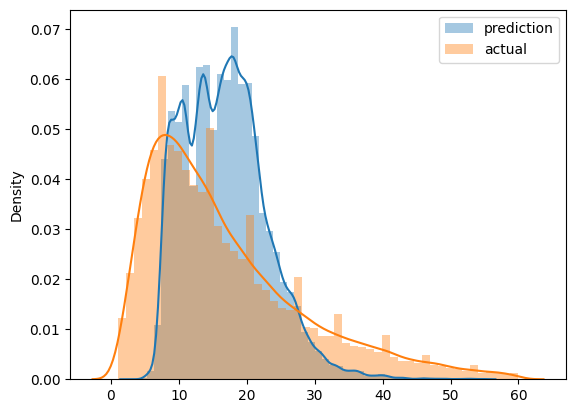

In [15]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")

plt.legend()

In [16]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)
    
    return df

In [17]:
df_train = read_dataframe('../../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../../data/green_tripdata_2021-02.parquet')

In [18]:
len(df_train), len(df_val)

(73908, 61921)

In [19]:
df_train['PU_DO'] = df_train['PULocationID'] + "_" + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + "_" + df_val['DOLocationID']

In [20]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [21]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715206931833

In [23]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [24]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "cristian")
    
    mlflow.log_param("train-data-path", "../../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "../../data/green_tripdata_2021-02.parquet")
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

### hyper parameters tuning

In [25]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [26]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [27]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        
    return {"loss": rmse, "status": STATUS_OK}

In [ ]:
# search_space = {
#     "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
#     "learning_rate": hp.loguniform("learning_rate", -3, 0), # exp(-3) ~ exp(0) 
#     "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
#     "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
#     "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
#     "objective": "reg:linear",
#     "seed": 42,
# }

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials(),
# )

[18:21:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.58897                          
[1]	validation-rmse:13.32568                          
[2]	validation-rmse:11.05883                          
[3]	validation-rmse:9.52200                           
[4]	validation-rmse:8.50359                           
[5]	validation-rmse:7.84384                           
[6]	validation-rmse:7.41632                           
[7]	validation-rmse:7.13998                           
[8]	validation-rmse:6.95704                           
[9]	validation-rmse:6.83679                           
[10]	validation-rmse:6.75457                          
[11]	validation-rmse:6.69968                          
[12]	validation-rmse:6.66074                          
[13]	validation-rmse:6.63156                          
[14]	validation-

In [ ]:
params = {
    "learning_rate": 0.07287542635460222,
    "max_depth": 42,
    "min_child_weight": 1.0716896165989325,
    "objective": "reg:linear",
    "reg_alpha": 0.0570334550842306,
    "reg_lambda": 0.26020836636905287,
    "seed": 42,
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50,
)

2023/05/29 19:30:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '329bd459d3904b94892bd2bf3ea08d3d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[19:30:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.88656
[1]	validation-rmse:18.68507
[2]	validation-rmse:17.58058
[3]	validation-rmse:16.56515
[4]	validation-rmse:15.63389
[5]	validation-rmse:14.78109
[6]	validation-rmse:14.00089
[7]	validation-rmse:13.28872
[8]	validation-rmse:12.63806
[9]	validation-rmse:12.04640
[10]	validation-rmse:11.50757
[11]	validation-rmse:11.01853
[12]	validation-rmse:10.57392
[13]	validation-rmse:10.17165
[14]	validation-rmse:9.80663
[15]	validation-rmse:9.47752
[16]	validation-rmse:9.18030
[17]	validation-rmse:8.91233
[18]	validation-rmse:8.67013
[19]	validation-rmse:8.45130
[20]	validation-rmse:8.25568
[21]	validation-rmse:8.07972
[22]	validation-rmse:7.92106
[23]	validation-rmse:7.77889
[24]	validation-rmse:7.65111
[25]	validation-rmse:7.53557
[26]	validation-rmse:7.43252

2023/05/29 19:32:12 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2023/05/29 19:32:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ryujaesung/kade/mlops-zoomcamp/week2/experiment-tracking/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [29]:
best_params = {
    "learning_rate": 0.07287542635460222,
    "max_depth": 42,
    "min_child_weight": 1.0716896165989325,
    "objective": "reg:linear",
    "reg_alpha": 0.0570334550842306,
    "reg_lambda": 0.26020836636905287,
    "seed": 42,
}

with mlflow.start_run():
    
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50,
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
        
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[19:50:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.88656
[1]	validation-rmse:18.68507
[2]	validation-rmse:17.58058
[3]	validation-rmse:16.56515
[4]	validation-rmse:15.63389
[5]	validation-rmse:14.78109
[6]	validation-rmse:14.00089
[7]	validation-rmse:13.28872
[8]	validation-rmse:12.63806
[9]	validation-rmse:12.04640
[10]	validation-rmse:11.50757
[11]	validation-rmse:11.01853
[12]	validation-rmse:10.57392
[13]	validation-rmse:10.17165
[14]	validation-rmse:9.80663
[15]	validation-rmse:9.47752
[16]	validation-rmse:9.18030
[17]	validation-rmse:8.91233
[18]	validation-rmse:8.67013
[19]	validation-rmse:8.45130
[20]	validation-rmse:8.25568
[21]	validation-rmse:8.07972
[22]	validation-rmse:7.92106
[23]	validation-rmse:7.77889
[24]	validation-rmse:7.65111
[25]	validation-rmse:7.53557
[26]	validation-rmse:7.43252

/Users/ryujaesung/kade/mlops-zoomcamp/week2/experiment-tracking/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [30]:
logged_model = 'runs:/8ddc753de4e140a3879c6ae6e7846613/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

2023/05/29 19:53:30 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[19:53:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [31]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 8ddc753de4e140a3879c6ae6e7846613

In [32]:
xgboost_model = mlflow.xgboost.load_model(model_uri=logged_model)

[19:54:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [33]:
xgboost_model

In [34]:
y_pred = xgboost_model.predict(valid)

In [35]:
y_pred[:10]

array([14.763987 ,  7.025691 , 15.6022625, 24.27755  ,  9.218826 ,
       17.143955 , 11.255192 ,  8.459276 ,  9.065275 , 20.801144 ],
      dtype=float32)